In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import crosstab
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import minmax_scale

# **Plots 2D gaussian dataset**

In [3]:
def plotblobs(X,y,n_clusters):
    cor = ['red','blue','green']
    for k in range(n_clusters):
        idx = np.where(y==k)
        ax.scatter(X[idx,0],X[idx,1],c=cor[k],zorder=3,
                marker='o',alpha=0.3)
    ax.axis('equal')
    ax.grid(visible=True,zorder=1)

# **Generates 2D gaussian dataset**

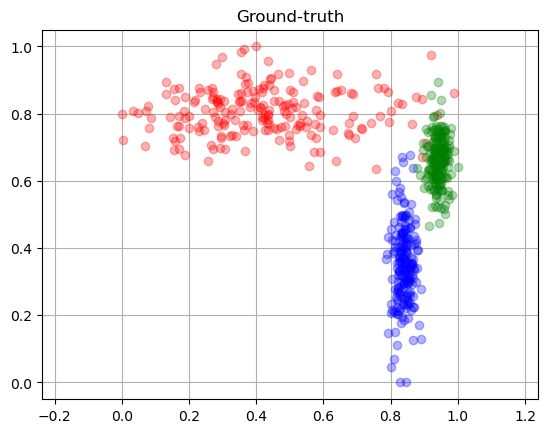

In [4]:
np.random.seed(91)
n_clusters = 3
n_samples = 600

[X,y] = make_blobs(n_samples = n_samples, n_features=2, 
                   centers = [[-2,3],[0,0],[.5,2]], 
                   cluster_std = [[1,.5],[.1,.8],[.1,.5]])

X = minmax_scale(X,feature_range=(0,1))

ax = plt.axes()
plotblobs(X,y,n_clusters)
ax.set(title='Ground-truth');

# **K-Medoids Clustering**

Number of iterations until convergence=3
col_0    0    1    2
row_0               
0      173   27    0
1        0   14  186
2        0  198    2


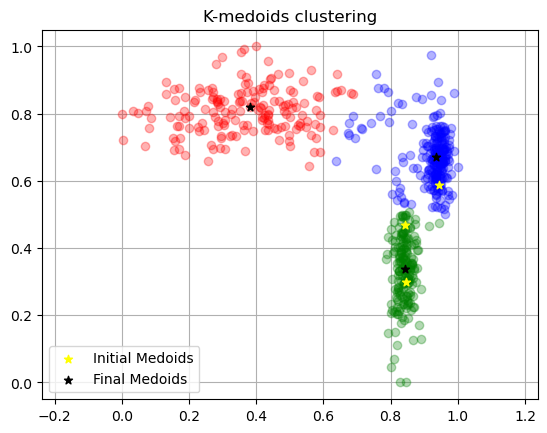

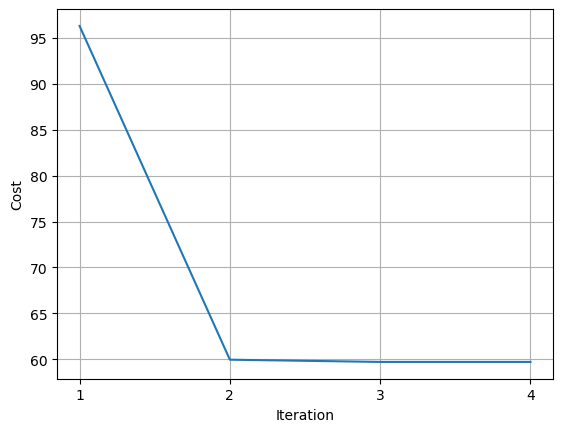

In [5]:
np.random.seed(911)

max_iterations = 1000

# min. abs. relative variation in the l2 norm of the medoid matrix
tol = 1e-8 

# stop criterion
# 0 - Frobennius norm of medoids matrix tolerance (K-means style)
# 1 - Decreasing cost (if the cost stops decreasing, halts)
stop_criterion = 1

# random initial medoids
medoids = np.random.permutation(n_samples)[:n_clusters]
initial_medoids = np.copy(medoids) # saves for futher use with K-means

cost = []
for i in range(max_iterations): 
    
     # current medoid matrix l2-norm
     oldl2norm = np.linalg.norm(X[medoids])
    
     # distances to medoids    
     d2m = pairwise_distances(X, X[medoids])
    
     # associates each sample to the nearest medoid
     kmedoids_cluster = np.argmin(d2m,axis=1)
    
     cost.append(0)   
     for k in range(n_clusters):
    
         # indexes of samples within k-th cluster
         idx_cluster_samples = np.where(kmedoids_cluster==k)[0]
        
         # pairwise distances among points within the k-th cluster
         p2p = pairwise_distances(X[idx_cluster_samples])
        
         # point which minimizes the intra-cluster dispersion
         intra_cluster_dispersion = np.sum(p2p,axis=1)
         idx = np.argmin(intra_cluster_dispersion)
       
         # updates cost function
         cost[i] = cost[i] + intra_cluster_dispersion[idx]
        
         # updates the k-th medoid
         medoids[k] = idx_cluster_samples[idx]
       
     # new medoid matrix l2-norm
     newl2norm = np.linalg.norm(X[medoids])
    
     if(stop_criterion==1):
         if((abs(oldl2norm-newl2norm)/oldl2norm)<tol):
             break
     else:
         if(cost[i]>=cost[i-1]):
            break
             
plt.figure()
ax = plt.axes()
plotblobs(X,kmedoids_cluster,n_clusters)

# plots initial and final medoids
ax.scatter(X[initial_medoids,0],X[initial_medoids,1],marker='*',c='yellow',zorder=4, label='Initial Medoids')
ax.scatter(X[medoids,0],X[medoids,1],marker='*',c='black',zorder=4, label='Final Medoids')
ax.legend(loc='lower left')
ax.set(title='K-medoids clustering')

# plot number of iterations
print('Number of iterations until convergence={iterations:.0f}'.format(iterations=i))

print(crosstab(y,kmedoids_cluster))

plt.figure()
plt.plot(cost)
plt.grid(visible=True)
plt.xlabel('Iteration')
L = list(range(i+1))
rotulos = L+np.ones([1,len(L)])
plt.xticks(ticks=L,labels=[int(k) for k in list(rotulos[0])])
plt.ylabel('Cost');

In [6]:
cost

[96.31764404994634, 59.95590026181213, 59.71307833759472, 59.71307833759472]

# **K-Means Clustering**

col_0    0    1    2
row_0               
0      171   29    0
1        0   14  186
2        0  198    2


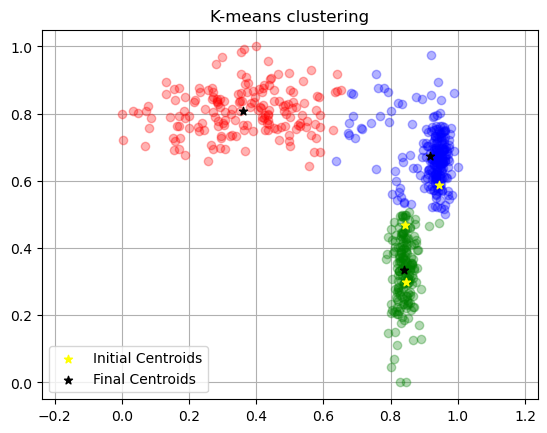

In [7]:
kmeans = KMeans(n_clusters=n_clusters,init=X[initial_medoids],
                n_init=1,max_iter=max_iterations,tol=tol,
                algorithm='full')

kmeans.fit(X)
kmeans_cluster = kmeans.predict(X)

plt.figure()
ax = plt.axes()
plotblobs(X,kmeans_cluster,n_clusters)

# plots initial centroids
ax.scatter(X[initial_medoids,0],X[initial_medoids,1],marker='*',c='yellow',zorder=4, label='Initial Centroids')

# plots final centroids
C = kmeans.cluster_centers_
ax.scatter(C[:,0],C[:,1],marker='*',c='black',zorder=4,label='Final Centroids')
ax.legend(loc='lower left')
ax.set(title='K-means clustering')

print(crosstab(y,kmeans_cluster))